In [36]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn

In [37]:
path='./creditcard.csv'
df=pd.read_csv(path)
df = df.drop("Time", axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [38]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


### Train-Val-Test Split

In [39]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)

normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

print("Training sets:\nx_train: {} y_train: {}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} y_test: {}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} y_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 29) y_train: (85588,)

Testing sets:
x_test: (28531, 29) y_test: (28531,)

Validation sets:
x_validate: (28531, 29) y_validate: (28531,)


### Normalize

In [40]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [49]:
def training(model, x_train, y_train):
    model = model.fit(x_train, y_train)
    train_acc = model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")
    
    
def evaluate(model, x_test, y_test):
    eval_acc  = model.score(x_test, y_test)
    preds     = model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    
    print(f"Eval Accuracy: {eval_acc:.3%}")
    print(f"Auc Score: {auc_score:.3%}")
  
    
    ## ROC Curve
    roc_plot = plot_roc_curve(model, x_test, y_test, name='Scikit-learn ROC Curve')
    plt.savefig("roc_plot.png")
    plt.show()
    plt.clf()
    
    ## Confusion Matrix
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("conf_matrix.png")
    
    mlflow.log_artifact("roc_plot.png")
    mlflow.log_artifact("conf_matrix.png")

## Model Training

INFO: 'model_training' does not exist. Creating a new experiment
Train Accuracy: 99.893%
Eval Accuracy: 99.874%
Auc Score: 85.341%


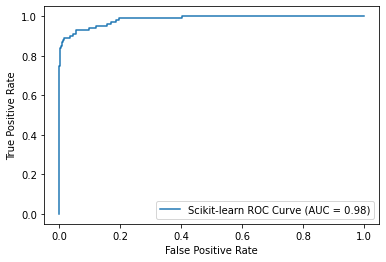

Model run:  fdb8ea146a1b49daa887bbc26ca48006


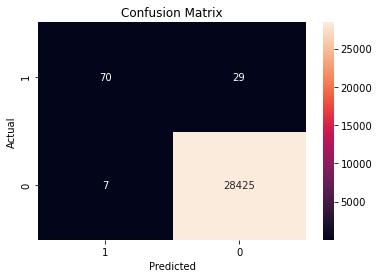

In [42]:
model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg', class_weight=190)
mlflow.set_experiment("model_training")

with mlflow.start_run():
    training(model, x_train, y_train)
    evaluate(model, x_test, y_test)
    mlflow.sklearn.log_model(model, "log_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

## Model Validation

In [43]:
anomaly_weights = [190,195,200,205,210]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

mlflow.set_experiment("Validation")
logs = []

for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            
            mlflow.log_param("anomaly_weight", weight)
            
            class_weights= {0: 1,1: weight}
            
            model = LogisticRegression(random_state=None,
                                    max_iter=400,
                                    solver='newton-cg',
                                    class_weight=class_weights).fit(x_validate[train], y_validate[train])
            
            
            train_acc = model.score(x_validate[train], y_validate[train])
            eval_acc  = model.score(x_validate[test], y_validate[test])
            preds     = model.predict(x_validate[test])
            
            mlflow.log_metric("train_acc", train_acc)
            mlflow.log_metric("eval_acc", eval_acc)
            
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
                
            mlflow.log_metric("auc_score", auc_score)
            
            
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            
            log = [model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(model, f"anomaly_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    
    print(f"\nAverages for Anomaly Weight: {weight}")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))
    for h in range(40): print('-', end="")

INFO: 'Search: 1' does not exist. Creating a new experiment

Averages for Anomaly Weight: 190
Accuracy:  0.9830008725548488
AUC:  0.9398368733057294
Best: 
Accuracy:  0.9851060101629577
AUC:  0.9906772207563764
----------------------------------------
Averages for Anomaly Weight: 195
Accuracy:  0.9827905676126827
AUC:  0.9397313571410315
Best: 
Accuracy:  0.9851060101629577
AUC:  0.9905892700087952
----------------------------------------
Averages for Anomaly Weight: 200
Accuracy:  0.9824751101994336
AUC:  0.9395730983624768
Best: 
Accuracy:  0.9851060101629577
AUC:  0.9904133685136324
----------------------------------------
Averages for Anomaly Weight: 205
Accuracy:  0.9819843986677125
AUC:  0.9393268640897965
Best: 
Accuracy:  0.9851060101629577
AUC:  0.9900615655233069
----------------------------------------
Averages for Anomaly Weight: 210
Accuracy:  0.9815988518905241
AUC:  0.9391333940915383
Best: 
Accuracy:  0.9847555633432626
AUC:  0.9897977132805629
-------------------------

## Model Retraining with Optimization

LogisticRegression(class_weight={0: 1, 1: 190}, max_iter=400,
                   solver='newton-cg')
Train Accuracy: 98.527%
Eval Accuracy: 98.584%
Auc Score: 93.753%


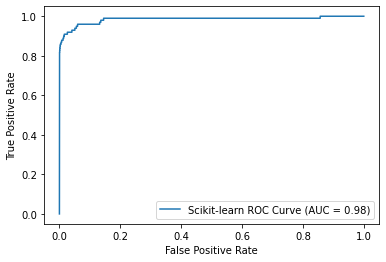

Model run:  468e27197d9e475da6ed8d60ed0666fe


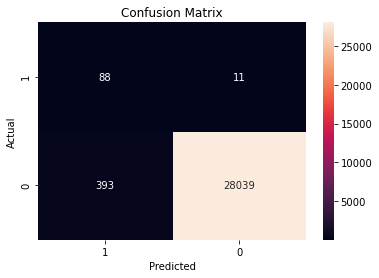

In [58]:
model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg', class_weight= {0: 1,1:190})
mlflow.set_experiment("model_training")
print(model)
with mlflow.start_run():
    training(model, x_train, y_train)
    evaluate(model, x_test, y_test)
    mlflow.sklearn.log_model(model, "log_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

## Loading & Model Testing

In [63]:
## Best weight at 190

loaded_model = mlflow.sklearn.load_model("runs:/468e27197d9e475da6ed8d60ed0666fe/log_model")
loaded_model.score(x_test, y_test)

0.985839963548421